## 强化学习
强化学习解决问题的思想主要是：智能体通过动作与环境进行交互，然后智能体在动作和环境的作用下会产生新的状态，同时环境会给出一个立即回报。智能体和环境不断交互从而产生很多数据，强化学习算法就可以利用这些数据修改智能体的动作策略，再产生新的数据，如此循环。在多次迭代学习后，智能体就能学习到完成任务的最优动作（最优策略）了。  

将强化学习应用于网格世界（grid world），以解决所谓的状态值函数（state value function）。这个函数告诉我们，在某种状态下，t的好坏取决于从该state可以获得的未来反馈。grid world任务图大致如下：
![gridworld任务图](F:/sjb/second/第四次/gridworld.jpg)

图中$4\times4$的网格图中的每一个网格都是一个状态，在这个任务中，智能体到达灰色方块的情况即为终止状态。  
智能体的动作有向上、向下、向左和向右四种可能，执行每个动作都将会对状态进行一个改变。只有一种情况是例外：当执行动作后，智能体将越出网格图边界，即碰撞上了墙壁，在这种情况下，设定这里的最终状态与初始状态相同。同时，对于墙上的每次移动，除非初始状态就是终止状态（也就是本来就在灰色方块上了，反馈为0且无需进一步动作，任务已经完成），否则将给出-1的反馈。  

有了上述的规则设定，智能体就可以选择动作来完成任务，那么它选择动作的方式是什么呢，这个选择动作的规则就是所谓策略。这里就采用随机策略，即它选择进行四个方向的动作的概率是相等的，都是25%。在这样的策略下，如何才能得到在每个状态下（即在网格图中的每一个网格时）的最佳动作呢？

定义以下标记： 
St： t的状态下
Rt： 进入t+1状态时获得反馈
At： t状态下进行的动作

下面采用三种方法求解：（1）动态规划（2）蒙特卡洛模拟（3）时间差(td)




## 动态规划

在这些网格中，除了灰色网格直接是终止状态，其余网格（状态）是有好坏程度的。比如，与两个灰色网格直接相邻的四个网格，在由随机策略选择动作时是有概率直接到达终止状态的。这里，我们需要将各个网格（状态）的好坏程度进行一个量化。那么对每个状态St，给出一个状态值函数V（St），能得到其包括所有未来反馈总和的值。  

状态值函数为：
$V(s)\longleftarrow\sum_a \pi(a\mid s)$ $\sum_{s',r} p(s',r\mid s,a)[r+\gamma V(s')]$  

其中  
$\pi(a\mid s)$为根据我们的策略在状态s下选择动作a的概率  （这里为0.25，因为我们选择了随机策略，且有4种可能）  

$\sum_a$为所有动作之和  

$p(s',r\mid s,a)$为在状态s和选择动作a的条件下  以状态s’终止和得到反馈r 的概率  （这里为1，因为动作是确定性的 且反馈总是为-1）  

$\sum_{s',r}$为所有终止状态s’和反馈r的 总和  

$[r+\gamma V(s')]$为反馈r（这里为-1）加上 折扣因子gamma $\times$ 终止状态s’的预期值

从一个值函数开始，该函数是一个$4\times4$维度（与网格图相同大小）的带有零的数组。现在我们迭代每个状态（也就是每个网格），计算它的新值。  
这里我没太很确定地理解，我认为应该是每个状态的计算方式为：反馈（-1）加上每个相邻状态s'的值的加权和。  
注意两件事：V（s'）是相邻（也有可能是终止）状态s'的期望值（在开始时，因为我们用零初始化值函数，所以期望值为0）。  
最后，V（s'）要乘以$\gamma$，这是折扣因子。  
最后，反复重复此过程，我们会“扫描”并更新所有状态的状态值函数。这些值可以迭代更新，直到达到收敛。事实上，在迭代策略评估算法中，可以看到计算出来的delta矩阵，它反映了当前状态值相对于先前值的变化程度。这些增量在迭代中衰减，并且应该在无穷远处达到0，就完成了任务。


在这个任务中，我们令$\gamma=1$，但折扣因子的概念是立即反馈（方程中的r）比未来的反馈更为重要（由s'的值反映），我们可以通过调整gamma的数值来反映这个事实。这个gamma的值的意义，课上的例子就简明易懂：如果要我做一件事，十年后才会给我奖励，而做另一件事马上就可以得到奖励，那么就时间上来说，马上可以得到奖励的这个状态的肯定会优先考虑，权重自然会高。

下面首先是代码的一些参数：  
gamma：      折扣因子$\gamma$  
rewardSize： 反馈r  
gridSize：   网格图的长和宽  
terminationStates：终止状态的矩阵，当到达最左上角和最右下角时终止  
actions：    动作矩阵，分别为向下、向上、向右、向左四个方向  
numIterations：总共的迭代次数

In [37]:
import numpy as np
from tqdm import tqdm           #该模块中有进度条美化方法
import matplotlib.pyplot as plt
import seaborn as sns           #可视化库
import random

sns.set_style("darkgrid") #设置风格
%pylab inline


gamma = 1         # 折扣因子
rewardSize = -1   # 反馈r
gridSize = 4      # 网格图尺寸
terminationStates = [[0,0], [gridSize-1, gridSize-1]]   #终止状态
actions = [[-1, 0], [1, 0], [0, 1], [0, -1]]   #动作矩阵
numIterations = 1000   #迭代次数

Populating the interactive namespace from numpy and matplotlib


D:\python3.7\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['gamma', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


在这里定义做出动作后的反馈函数，如果最初的位置就在终止位置上，则返回最初位置，以及反馈0；每次迭代的最终位置则是每次初始位置加上动作之后的位置。返回最终位置和反馈值。

In [38]:
def actionRewardFunction(initialPosition, action):
    if initialPosition in terminationStates:
        return initialPosition, 0
    reward = rewardSize
    finalPosition = np.array(initialPosition) + np.array(action)
    if -1 in finalPosition or 4 in finalPosition:  
        finalPosition = initialPosition
    return finalPosition, reward

初始化状态值矩阵以及状态矩阵，状态矩阵也就是各个网格点的位置（坐标），并输出步数为0时的值函数的值。

In [39]:
valueMap = np.zeros((gridSize, gridSize))
states = [[i, j] for i in range(gridSize) for j in range(gridSize)]

# 步数为 0 处的值函数的值
valueMap

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

创建deltas矩阵，它反映了当前状态值相对于先前值的变化程度。然后进行多次迭代，每次迭代都能产生一个状态值矩阵，状态值通过之前所提到的状态值函数公式计算得到。分别输出1次、2次、3次、10次、100次、1000次迭代后的状态值矩阵，以及deltas增量矩阵。  
这些增量在迭代中衰减，并且应该在无穷远处达到0，那么就代表完成了任务。而在迭代1000次后我们可以看到deltas矩阵已全为0，代表已收敛。  
但是这里我也有一个疑惑，在博客中进行三次迭代后就已经达到最优动作了，但是其矩阵数据显示却并未收敛。

In [40]:
deltas = []

for it in range(numIterations):
    copyValueMap = np.copy(valueMap)
    deltaState = []
    for state in states:
        weightedRewards = 0
        for action in actions:
            finalPosition, reward = actionRewardFunction(state, action)
            weightedRewards += (1/len(actions))*(reward+(gamma*valueMap[finalPosition[0], finalPosition[1]]))
        deltaState.append(np.abs(copyValueMap[state[0], state[1]]-weightedRewards))
        copyValueMap[state[0], state[1]] = weightedRewards
    deltas.append(deltaState)
    valueMap = copyValueMap
    if it in[0,1,2,9, 99, numIterations-1]:        
        print("Iteration {}".format(it+1))
        print(valueMap)
        print("")       
        print(deltas[it])
        print("")

Iteration 1
[[ 0. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1.  0.]]

[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]

Iteration 2
[[ 0.   -1.75 -2.   -2.  ]
 [-1.75 -2.   -2.   -2.  ]
 [-2.   -2.   -2.   -1.75]
 [-2.   -2.   -1.75  0.  ]]

[0.0, 0.75, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 0.75, 0.0]

Iteration 3
[[ 0.     -2.4375 -2.9375 -3.    ]
 [-2.4375 -2.875  -3.     -2.9375]
 [-2.9375 -3.     -2.875  -2.4375]
 [-3.     -2.9375 -2.4375  0.    ]]

[0.0, 0.6875, 0.9375, 1.0, 0.6875, 0.875, 1.0, 0.9375, 0.9375, 1.0, 0.875, 0.6875, 1.0, 0.9375, 0.6875, 0.0]

Iteration 10
[[ 0.         -6.13796997 -8.35235596 -8.96731567]
 [-6.13796997 -7.73739624 -8.42782593 -8.35235596]
 [-8.35235596 -8.42782593 -7.73739624 -6.13796997]
 [-8.96731567 -8.35235596 -6.13796997  0.        ]]

[0.0, 0.441741943359375, 0.65478515625, 0.730255126953125, 0.441741943359375, 0.579315185546875, 0.649261474609375, 0.65478515625, 0.6547

最后将上面1000次迭代的收敛程度（增量值）通过图表进行一个绘制，更为直观。可以看到在很少的迭代次数时就已经收敛了。

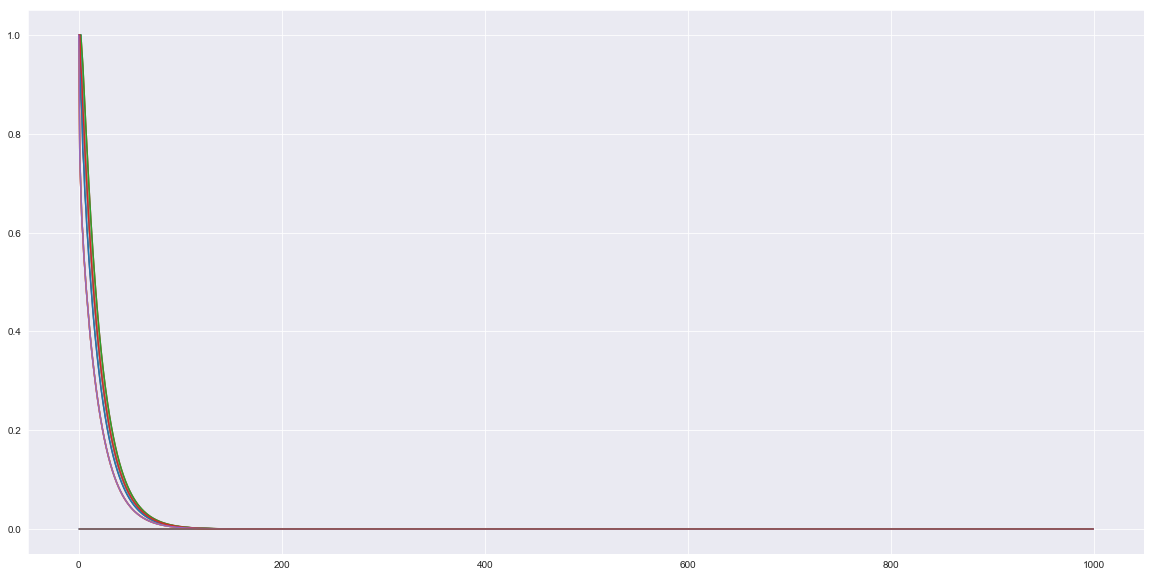

In [41]:
plt.figure(figsize=(20, 10))
plt.plot(deltas)

## 蒙特卡洛方法

前面已经导入了各种库，当gamma设置为0.6时：

In [51]:
gamma = 0.6    # 折扣因子
rewardSize = -1
gridSize = 4
terminationStates = [[0,0], [gridSize-1, gridSize-1]]
actions = [[-1, 0], [1, 0], [0, 1], [0, -1]]
numIterations = 10000

# 初始化
V = np.zeros((gridSize, gridSize))
returns = {(i, j):list() for i in range(gridSize) for j in range(gridSize)}
deltas = {(i, j):list() for i in range(gridSize) for j in range(gridSize)}
states = [[i, j] for i in range(gridSize) for j in range(gridSize)]


In [55]:
def generateEpisode():
    initState = random.choice(states[1:-1])
    episode = []    
    while True:
        if list(initState) in terminationStates: 
            return episode
        action = random.choice(actions)
        finalState = np.array(initState)+np.array(action)
        if -1 in list(finalState) or gridSize in list(finalState):
            finalState = initState
        episode.append([list(initState), action,rewardSize, list(finalState)])
        initState = finalState

In [56]:
for it in tqdm(range(numIterations)):
    episode = generateEpisode()
    G = 0     
    for i, step in enumerate(episode[::-1]):
        G = gamma*G + step[2]
        if step[0] not in[x[0] for x in episode[::-1][len(episode)-i:]]:
            idx = (step[0][0], step[0][1])
            returns [idx].append(G)
            newValue = np.average(returns[idx])
            deltas[idx[0], idx[1]].append(np.abs(V[idx[0], idx[1]]-newValue))
            V[idx[0], idx[1]] = newValue

V

100%|███████████████████████████████████| 10000/10000 [00:13<00:00, 755.78it/s]


array([[ 0.        , -1.62822372, -2.21762667, -2.38380985],
       [-1.62538056, -2.09391681, -2.27403112, -2.20902804],
       [-2.21104431, -2.27253244, -2.10196126, -1.62499904],
       [-2.38496644, -2.22024834, -1.64869618,  0.        ]])

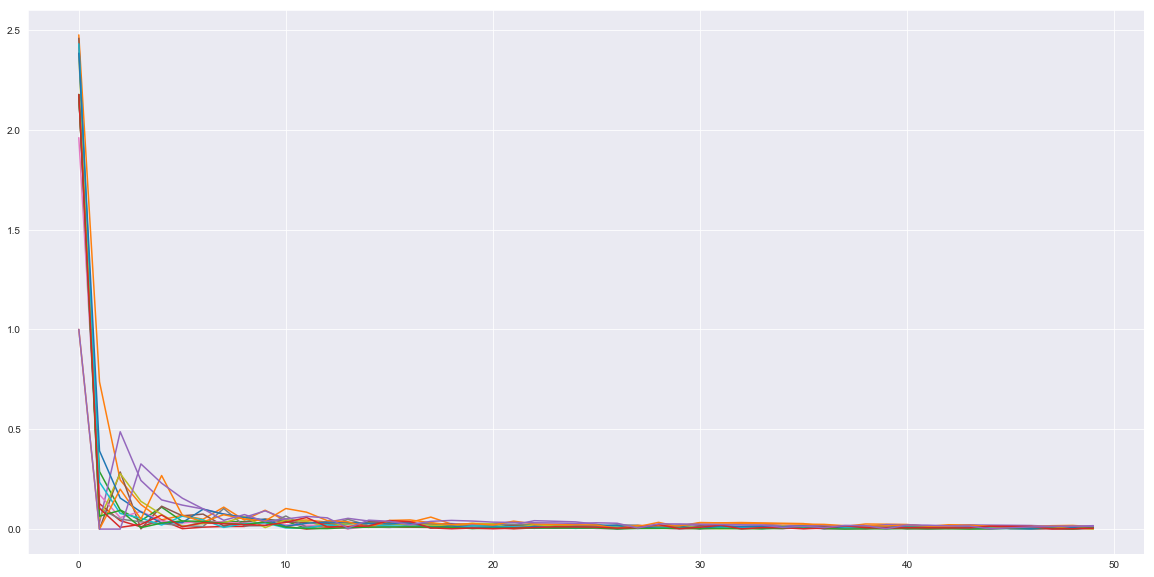

In [57]:
plt.figure(figsize=(20,10))
all_series = [list(x)[:50] for x in deltas.values()]
for series in all_series:
    plt.plot(series)

gamma设置为1.0时，可以看到收敛速度减慢了，所以调整gamma值能改变收敛时间。

100%|███████████████████████████████████| 10000/10000 [00:13<00:00, 398.17it/s]


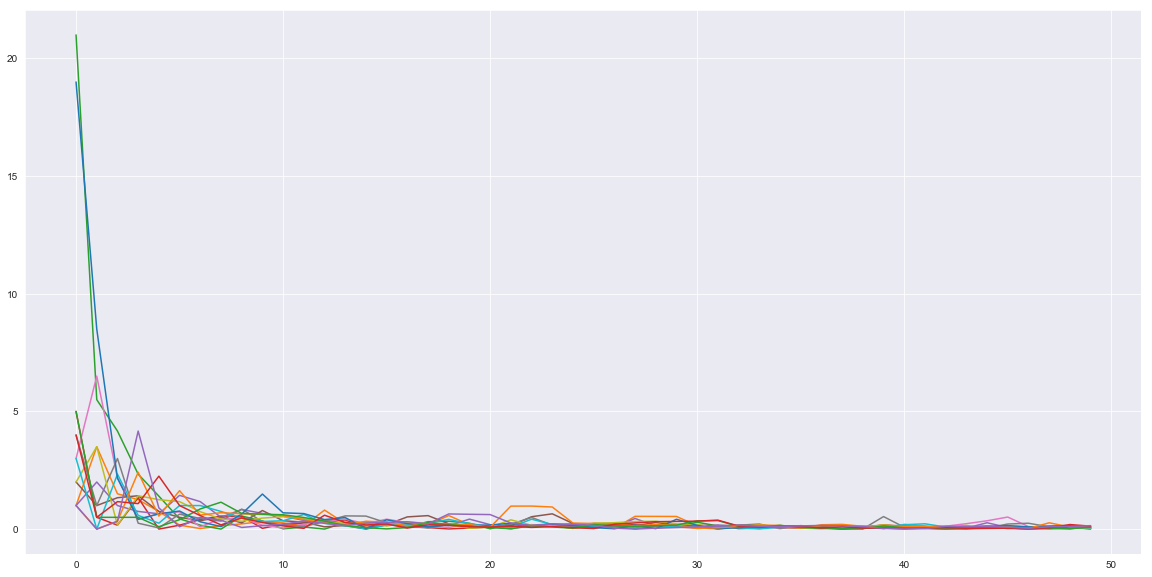

In [59]:
gamma = 1.0
rewardSize = -1
gridSize = 4
terminationStates = [[0,0], [gridSize-1, gridSize-1]]
actions = [[-1, 0], [1, 0], [0, 1], [0, -1]]
numIterations = 10000

# 初始化
V = np.zeros((gridSize, gridSize))
returns = {(i, j):list() for i in range(gridSize) for j in range(gridSize)}
deltas = {(i, j):list() for i in range(gridSize) for j in range(gridSize)}
states = [[i, j] for i in range(gridSize) for j in range(gridSize)]

def generateEpisode():
    initState = random.choice(states[1:-1])
    episode = []    
    while True:
        if list(initState) in terminationStates: 
            return episode
        action = random.choice(actions)
        finalState = np.array(initState)+np.array(action)
        if -1 in list(finalState) or gridSize in list(finalState):
            finalState = initState
        episode.append([list(initState), action,rewardSize, list(finalState)])
        initState = finalState


for it in tqdm(range(numIterations)):
    episode = generateEpisode()
    G = 0   
    #print(episode)  
    for i, step in enumerate(episode[::-1]):
        G = gamma*G + step[2]
        if step[0] not in[x[0] for x in episode[::-1][len(episode)-i:]]:
            idx = (step[0][0], step[0][1])
            returns [idx].append(G)
            newValue = np.average(returns[idx])
            deltas[idx[0], idx[1]].append(np.abs(V[idx[0], idx[1]]-newValue))
            V[idx[0], idx[1]] = newValue


plt.figure(figsize=(20,10))
all_series = [list(x)[:50] for x in deltas.values()]
for series in all_series:
    plt.plot(series)

## 时间差异式学习

将gamma设置为0.5，步长alpha设置为0.5：

In [6]:
gamma = 0.5    # 折扣因子
rewardSize = -1
gridSize = 4
alpha = 0.5    # stepSize步长 范围为(0,1] 
terminationStates = [[0,0], [gridSize-1, gridSize-1]]
actions = [[-1, 0], [1, 0], [0, 1], [0, -1]]
numIterations = 10000

# 初始化
V = np.zeros((gridSize, gridSize))
returns = {(i, j):list() for i in range(gridSize) for j in range(gridSize)}
deltas = {(i, j):list() for i in range(gridSize) for j in range(gridSize)}
states = [[i, j] for i in range(gridSize) for j in range(gridSize)]

def generateInitialState():
    initState = random.choice(states[1:-1])    
    return initState
def generateNextAction():
    return random.choice(actions)
def takeAction(state, action): 
    if list(state) in terminationStates:
        return 0, None
    finalState = np.array(state)+np.array(action)  
    if -1 in list(finalState) or gridSize in list(finalState):
        finalState = state   
    return rewardSize, list(finalState)

for it in tqdm(range(numIterations)):
    state = generateInitialState()
    while True:
        action = generateNextAction()
        reward, finalState = takeAction(state, action)      
        # 我们到了终点    
        if finalState is None:   
            break
        # 修改 Value 函数
        before =  V[state[0], state[1]]
        V[state[0], state[1]] += alpha*(reward + gamma*V[finalState[0], finalState[1]] - V[state[0], state[1]])
        deltas[state[0], state[1]].append(float(np.abs(before-V[state[0], state[1]])))
        state = finalState
        
V

100%|██████████████████████████████████| 10000/10000 [00:03<00:00, 2714.70it/s]


array([[ 0.        , -1.30663731, -1.98788795, -1.99299091],
       [-1.58073686, -1.75319277, -1.99041082, -1.86768633],
       [-1.83916163, -1.96062557, -1.97638495, -1.24014456],
       [-1.99523128, -1.90115322, -1.30937179,  0.        ]])

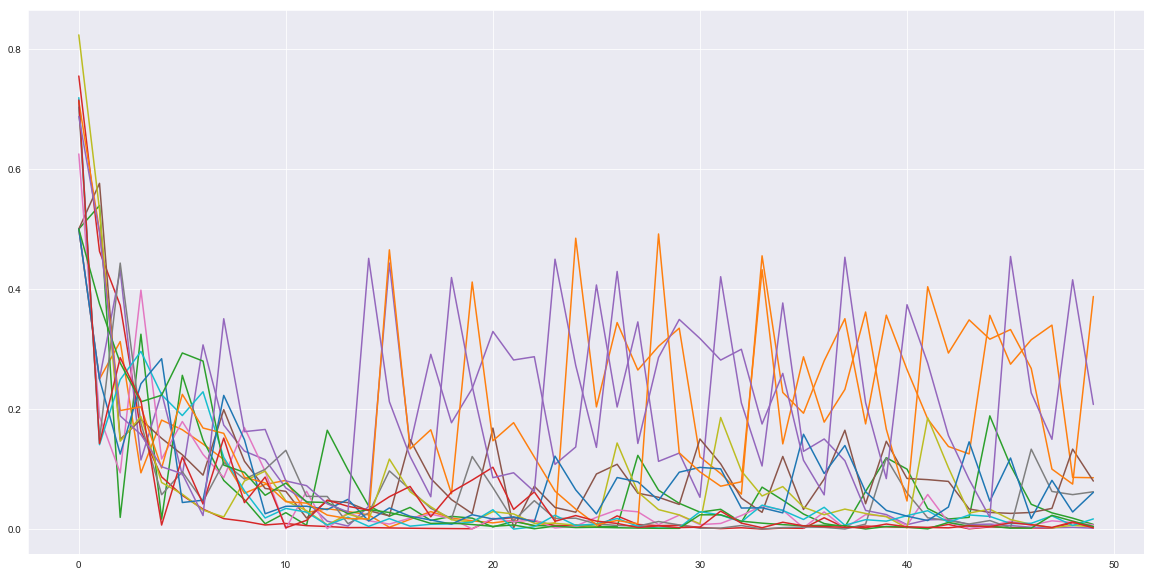

In [7]:
plt.figure(figsize=(20,10))
all_series = [list(x)[:50] for x in deltas.values()]
for series in all_series:
     plt.plot(series)

可以看到在gamma和alpha都设置为0.5时无法收敛，即无法得到最优策略。下面将gamma和alpha均设置为0.1：

100%|██████████████████████████████████| 10000/10000 [00:04<00:00, 2259.67it/s]


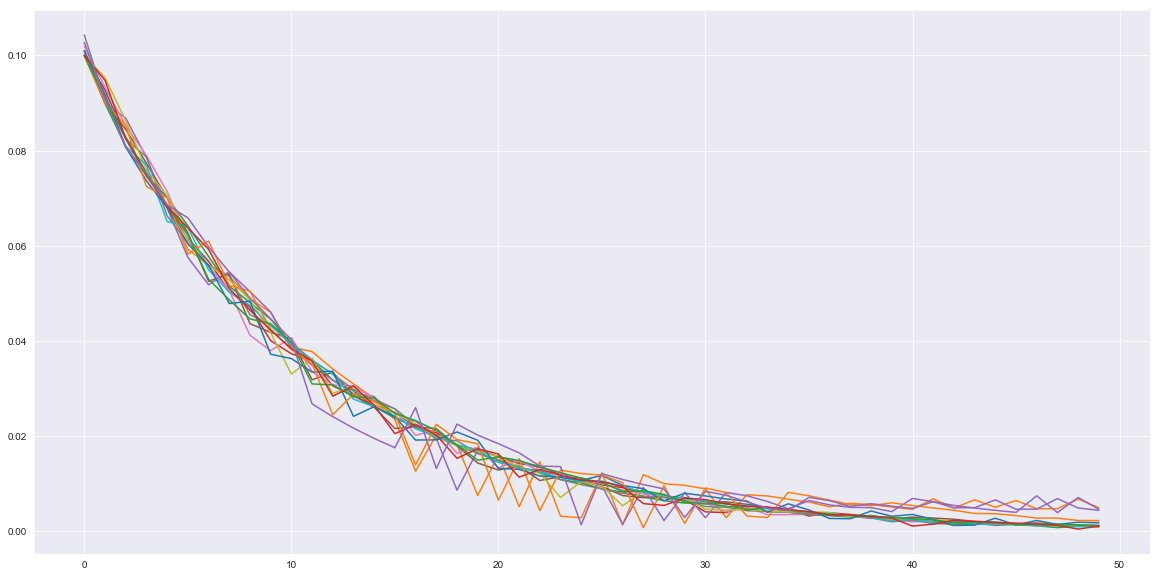

In [63]:
gamma = 0.1    # 折扣因子
rewardSize = -1
gridSize = 4
alpha = 0.1    # stepSize 步长  范围为(0,1] 
terminationStates = [[0,0], [gridSize-1, gridSize-1]]
actions = [[-1, 0], [1, 0], [0, 1], [0, -1]]
numIterations = 10000

# 初始化
V = np.zeros((gridSize, gridSize))
returns = {(i, j):list() for i in range(gridSize) for j in range(gridSize)}
deltas = {(i, j):list() for i in range(gridSize) for j in range(gridSize)}
states = [[i, j] for i in range(gridSize) for j in range(gridSize)]


def generateInitialState():
    initState = random.choice(states[1:-1])    
    return initState
def generateNextAction():
    return random.choice(actions)
def takeAction(state, action): 
    if list(state) in terminationStates:
        return 0, None
    finalState = np.array(state)+np.array(action)
    # if robot crosses wall    
    if -1 in list(finalState) or gridSize in list(finalState):
        finalState = state   
    return rewardSize, list(finalState)

for it in tqdm(range(numIterations)):
    state = generateInitialState()
    while True:
        action = generateNextAction()
        reward, finalState = takeAction(state, action)      
        # 我们到了终点    
        if finalState is None:   
            break
        # 修改 Value 函数
        before =  V[state[0], state[1]]
        V[state[0], state[1]] += alpha*(reward + gamma*V[finalState[0], finalState[1]] - V[state[0], state[1]])
        deltas[state[0], state[1]].append(float(np.abs(before-V[state[0], state[1]])))
        state = finalState


plt.figure(figsize=(20,10))
all_series = [list(x)[:50] for x in deltas.values()]
for series in all_series:
    plt.plot(series)

可以看到在gamma和alpha均设置为0.1的情况下最后能够收敛。